In [1]:
!pip install unidecode
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.5 MB/s eta 0:00:00


## Import Library dan Dataset

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, LSTM, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from string import punctuation
from unidecode import unidecode
from nltk.util import ngrams
from contractions import fix
import nltk


df = pd.read_csv('Emotion_classify_Data.csv')

In [4]:
df

Comment Emotion
0     i seriously hate one subject to death but now ...    fear
1                    im so full of life i feel appalled   anger
2     i sit here to write i start to dig out my feel...    fear
3     ive been really angry with r and i feel like a...     joy
4     i feel suspicious if there is no one outside l...    fear
...                                                 ...     ...
5932                 i begun to feel distressed for you    fear
5933  i left feeling annoyed and angry thinking that...   anger
5934  i were to ever get married i d have everything...     joy
5935  i feel reluctant in applying there because i w...    fear
5936  i just wanted to apologize to you because i fe...   anger

[5937 rows x 2 columns]

In [5]:
category = pd.get_dummies(df.Emotion)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Emotion')
df_baru

Comment  anger  fear  joy
0     i seriously hate one subject to death but now ...      0     1    0
1                    im so full of life i feel appalled      1     0    0
2     i sit here to write i start to dig out my feel...      0     1    0
3     ive been really angry with r and i feel like a...      0     0    1
4     i feel suspicious if there is no one outside l...      0     1    0
...                                                 ...    ...   ...  ...
5932                 i begun to feel distressed for you      0     1    0
5933  i left feeling annoyed and angry thinking that...      1     0    0
5934  i were to ever get married i d have everything...      0     0    1
5935  i feel reluctant in applying there because i w...      0     1    0
5936  i just wanted to apologize to you because i fe...      1     0    0

[5937 rows x 4 columns]

In [6]:
content = df_baru['Comment'].values
label = df_baru[['fear','anger','joy']].values

## Split Data

In [7]:
from sklearn.model_selection import train_test_split
content_latih, content_test, label_latih, label_test = train_test_split(content, label, test_size=0.2)

## Tokenization

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Fungsi Penghilang Stopwords dan Tanda Baca
def preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))

    tokenizer = RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(sentence)

    # Stemming using SnowballStemmer (NLTK) for English
    stemmer = SnowballStemmer("english")
    words = [stemmer.stem(word.lower()) for word in word_tokens if word.lower() not in stop_words]

    return ' '.join(words)

# Fungsi Penghilang Blank, Fixer, dan Proses Ekspansi Teks
def remove_blank(text):
    text_data = text.replace("\n", "").replace("\t", "")
    return text_data

def expanding_text(text):
    text_data = fix(text)  # Pastikan ada fungsi fix atau sesuaikan dengan kebutuhan
    return text_data

# Fungsi untuk menangani karakter aksen
def handle_accented_chr(text):
    text_data = unidecode(text)
    return text_data

# Fungsi Pembersihan Teks
def clean_text(text):
    text_data = text.lower()
    tokens = word_tokenize(text_data)
    clean_data = [i for i in tokens if i not in punctuation]
    clean_data = [i for i in clean_data if i.isalpha()]
    clean_data = [i for i in clean_data if len(i) > 1]
    return clean_data

# Fungsi Lematisasi
def lemmatization(text_list):
    final_list = []
    lemmatizer = WordNetLemmatizer()
    for i in text_list:
        w = lemmatizer.lemmatize(i)
        final_list.append(w)
    return " ".join(final_list)

# Menghilangkan stopwords dan tanda baca dari setiap kalimat dalam dataset
content_latih = [preprocess_text(sentence) for sentence in content_latih]
content_test = [preprocess_text(sentence) for sentence in content_test]

# Menghilangkan blank dari setiap kalimat dalam dataset
content_latih = [remove_blank(sentence) for sentence in content_latih]
content_test = [remove_blank(sentence) for sentence in content_test]

# Proses ekspansi teks
content_latih = [expanding_text(sentence) for sentence in content_latih]
content_test = [expanding_text(sentence) for sentence in content_test]

# Menangani karakter aksen
content_latih = [handle_accented_chr(sentence) for sentence in content_latih]
content_test = [handle_accented_chr(sentence) for sentence in content_test]

# Membersihkan teks
content_latih_cleaned = [clean_text(sentence) for sentence in content_latih]
content_test_cleaned = [clean_text(sentence) for sentence in content_test]

# Lematisasi
content_latih_lemmatized = [lemmatization(sentence) for sentence in content_latih_cleaned]
content_test_lemmatized = [lemmatization(sentence) for sentence in content_test_cleaned]

# Tokenizer
tokenizer = Tokenizer(num_words=40000, oov_token='x')
tokenizer.fit_on_texts(content_latih_lemmatized)

# Tokenize dan pad urutan
sekuens_latih = tokenizer.texts_to_sequences(content_latih_lemmatized)
sekuens_test = tokenizer.texts_to_sequences(content_test_lemmatized)

# Padding
maxlen = 20
padded_latih = pad_sequences(sekuens_latih, padding='post', maxlen=maxlen, truncating='post')
padded_test = pad_sequences(sekuens_test, padding='post', maxlen=maxlen, truncating='post')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Pembuatan Model

In [12]:
model = tf.keras.Sequential([
    Embedding(input_dim=40000, output_dim=2048, input_length=20),
    Bidirectional(LSTM(2048, return_sequences=True)),
    Bidirectional(LSTM(1024, return_sequences=True)),
    Bidirectional(LSTM(512, return_sequences=True)),
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(2048, activation='relu'),
    Dropout(0.1),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


## Callback

In [13]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if accuracy is not None and val_accuracy is not None:
            if accuracy > 0.9 and val_accuracy > 0.90:
                print("\nAkurasi dan val_akurasi sudah lebih dari 90%!")
                self.model.stop_training = True

early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)

callbacks = [early_stopping, MyCallback(),ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)]

## Pelatihan Model

In [14]:
num_epochs = 100
history = model.fit(padded_latih, label_latih, epochs=num_epochs,batch_size = 64,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=callbacks)

Epoch 1/100
75/75 - 89s - loss: 1.0991 - accuracy: 0.3348 - val_loss: 1.0983 - val_accuracy: 0.3401 - lr: 1.0000e-04 - 89s/epoch - 1s/step
Epoch 2/100
75/75 - 64s - loss: 1.0318 - accuracy: 0.4384 - val_loss: 0.8708 - val_accuracy: 0.5429 - lr: 1.0000e-04 - 64s/epoch - 859ms/step
Epoch 3/100
75/75 - 99s - loss: 0.6871 - accuracy: 0.6168 - val_loss: 0.6871 - val_accuracy: 0.6002 - lr: 1.0000e-04 - 99s/epoch - 1s/step
Epoch 4/100
75/75 - 109s - loss: 0.5559 - accuracy: 0.6618 - val_loss: 0.6538 - val_accuracy: 0.6599 - lr: 1.0000e-04 - 109s/epoch - 1s/step
Epoch 5/100
75/75 - 74s - loss: 0.4573 - accuracy: 0.7854 - val_loss: 0.6079 - val_accuracy: 0.7753 - lr: 1.0000e-04 - 74s/epoch - 988ms/step
Epoch 6/100
75/75 - 98s - loss: 0.2606 - accuracy: 0.9126 - val_loss: 0.4783 - val_accuracy: 0.8502 - lr: 1.0000e-04 - 98s/epoch - 1s/step
Epoch 7/100
75/75 - 28s - loss: 0.1640 - accuracy: 0.9478 - val_loss: 0.5620 - val_accuracy: 0.8056 - lr: 1.0000e-04 - 28s/epoch - 370ms/step
Epoch 8/100
75/7

In [15]:
model.evaluate(padded_latih, label_latih)

149/149 [==============================] - 11s 75ms/step - loss: 0.0151 - accuracy: 0.9964


[0.015053799375891685, 0.9964203238487244]

In [16]:
model.evaluate(padded_test, label_test)

38/38 [==============================] - 3s 75ms/step - loss: 0.4521 - accuracy: 0.9057


[0.45208582282066345, 0.9057239294052124]

## Plot Loss Training

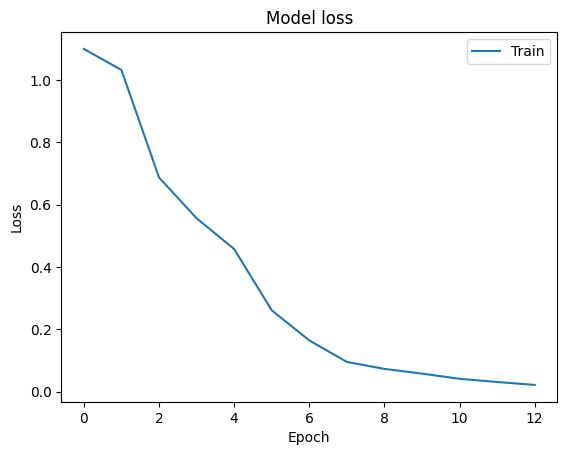

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

## Plot Akurasi Training

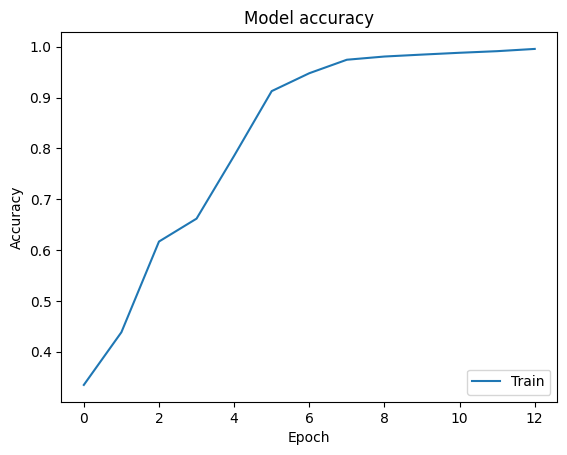

In [18]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

## Plot Loss Validation

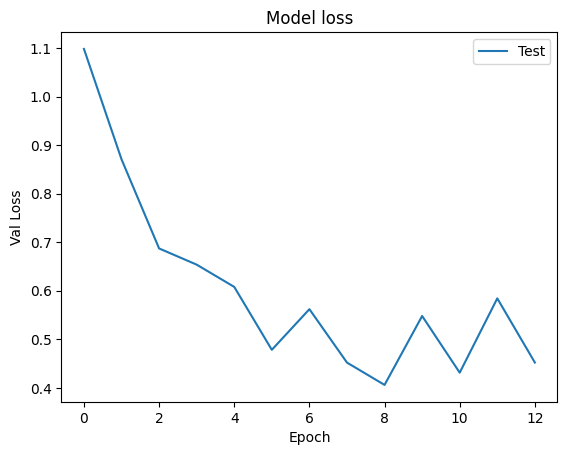

In [19]:
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Val Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper right')
plt.show()

## Plot Akurasi Validation

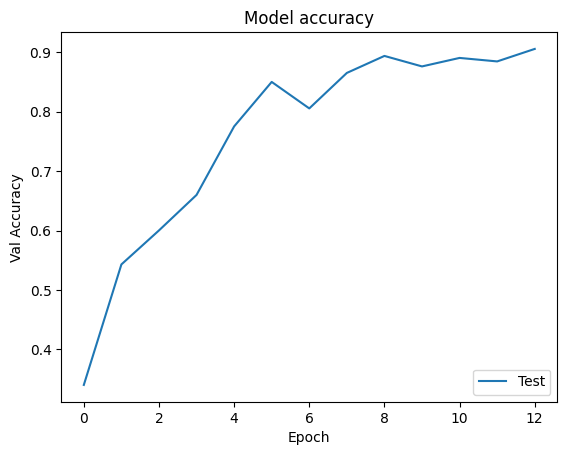

In [20]:
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='lower right')
plt.show()